# Day 8 - Open Street Maps

Accessing OSM data using Overpass API. 

Good article [here](https://towardsdatascience.com/loading-data-from-openstreetmap-with-python-and-the-overpass-api-513882a27fd0)

In [228]:
import requests
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
import matplotlib.pyplot as plt

#for colorbar
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import rasterio
from rasterio.plot import show as rioshow
import contextily as cx

# Fast food shops


## get and clean data
Get chicken shops + known brands by name (if not tagged with cuisine)

Helpful [tip](https://help.openstreetmap.org/questions/48794/overpass-api-union-doesnt-work) when debugging union code. 

In [20]:
#get data from OSM using Overpass API
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name="Greater London"][admin_level=5]->.searchArea;

(node["cuisine"="chicken"](area.searchArea); 
 way["cuisine"="chicken"](area.searchArea);
 rel["cuisine"="chicken"](area.searchArea);
 node["name"~"KFC|Morley's|Nando's|^Chicken|Piri Piri|Peri Peri"](area.searchArea);
 way["name"~"KFC|Morley's|Nando's|^Chicken|Piri Piri|Peri Peri"](area.searchArea);
 rel["name"~"KFC|Morley's|Nando's|^Chicken|Piri Piri|Peri Peri"](area.searchArea);
);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [46]:
#convert json into dataframe
df_dict = {"id":[], "type": [], "lat":[], "lon": [], "name":[],"brand":[], "cuisine":[], "amenity":[]}

for element in data['elements']:
    df_dict["id"].append(element["id"])
    df_dict["type"].append(element["id"])
    
    for tag in ["name", "brand", "cuisine", "amenity"]:
        try:
            df_dict[tag].append(element["tags"][tag])
        except KeyError:
            df_dict[tag].append("") 
    if element["type"]=="node":
        df_dict["lat"].append(element["lat"])
        df_dict["lon"].append(element["lon"])
    else:
        df_dict["lat"].append(element["center"]["lat"])
        df_dict["lon"].append(element["center"]["lon"])
        
df = pd.DataFrame.from_dict(df_dict)

In [53]:
# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, 
                          crs = 'EPSG:4326', 
                          geometry = geometry)
gdf.head()

,id,type,lat,lon,name,brand,cuisine,amenity,geometry
0,59932133,59932133,51.377740,-0.025343,KFC,KFC,chicken,fast_food,POINT (-0.02534 51.37774)
1,130216826,130216826,51.413614,-0.178088,Nando's,Nando's,chicken;portuguese,restaurant,POINT (-0.17809 51.41361)
2,249249967,249249967,51.617862,-0.311072,Nando's,Nando's,chicken;portuguese,restaurant,POINT (-0.31107 51.61786)
3,260283878,260283878,51.540145,-0.143901,KFC,KFC,chicken,fast_food,POINT (-0.14390 51.54015)
4,265255759,265255759,51.510171,-0.287978,Nando's,Nando's,chicken;portuguese,restaurant,POINT (-0.28798 51.51017)


In [147]:
#create column for chain or no chain
chain = []

for i in range(len(gdf)):
    if gdf["name"][i] in list(gdf["name"].value_counts().head(2).index):
        chain.append("International chain")
    elif gdf["name"][i] in list(gdf["name"].value_counts()[2:25].index):
        chain.append("Local chain")
    else:
        chain.append("Independent")

gdf["chain"] = chain

In [218]:
gdf["chain_binary"] = ["International chain" if i=="International chain" else "Local/independent" for i in gdf["chain"]]

In [219]:
gdf

,id,type,lat,lon,name,brand,cuisine,amenity,geometry,chain,chain_binary
0,59932133,59932133,51.377740,-0.025343,KFC,KFC,chicken,fast_food,POINT (-2821.114 6688385.526),International chain,International chain
1,130216826,130216826,51.413614,-0.178088,Nando's,Nando's,chicken;portuguese,restaurant,POINT (-19824.610 6694786.029),International chain,International chain
2,249249967,249249967,51.617862,-0.311072,Nando's,Nando's,chicken;portuguese,restaurant,POINT (-34628.399 6731322.679),International chain,International chain
3,260283878,260283878,51.540145,-0.143901,KFC,KFC,chicken,fast_food,POINT (-16018.953 6717401.068),International chain,International chain
4,265255759,265255759,51.510171,-0.287978,Nando's,Nando's,chicken;portuguese,restaurant,POINT (-32057.609 6712038.052),International chain,International chain
...,...,...,...,...,...,...,...,...,...,...,...
719,1089866481,1089866481,51.415398,-0.053385,Favorite Chicken & Ribs,,chicken,fast_food,POINT (-5942.769 6695104.361),Local chain,Local/independent
720,1097130387,1097130387,51.474408,-0.344210,Roosters Chicken,,chicken,fast_food,POINT (-38317.315 6705643.983),Independent,Local/independent
721,1099700570,1099700570,51.474225,-0.344517,Chesters,,chicken,fast_food,POINT (-38351.479 6705611.188),Independent,Local/independent
722,1104153596,1104153596,51.377853,0.100415,KFC,KFC,chicken,fast_food,POINT (11178.102 6688405.643),International chain,International chain


### london boroughs



In [59]:
#load london boroughs
london = gpd.GeoDataFrame.from_file("London_Borough_Excluding_MHW.geojson")

In [194]:
#join points into boroughs and calculate stats 
borough_stats = gpd.sjoin(gdf, london, how="left")
borough_stats = borough_stats.groupby(["NAME", "chain"])["id"].count().to_frame().unstack()
borough_stats.columns = borough_stats.columns.droplevel(level=0)
borough_stats["Total"] = borough_stats.sum(axis=1)
borough_stats["Chain_ratio"] = (borough_stats["International chain"] / borough_stats["Total"])
borough_stats = borough_stats.reset_index()
borough_stats.head()

chain,NAME,Independent,International chain,Local chain,Total,Chain_ratio
0,Barking and Dagenham,5.0,3.0,4.0,12.0,0.250000
1,Barnet,2.0,9.0,2.0,13.0,0.692308
2,Bexley,NaN,6.0,1.0,7.0,0.857143
3,Brent,18.0,8.0,10.0,36.0,0.222222
4,Bromley,5.0,8.0,2.0,15.0,0.533333


In [196]:
#join back with london frame
london = pd.merge(london, borough_stats, left_on="NAME", right_on="NAME", how="left")
london.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,Independent,International chain,Local chain,Total,Chain_ratio
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"MULTIPOLYGON (((-36811.020 6679699.611, -36801...",NaN,5.0,1.0,6.0,0.833333
1,Croydon,E09000008,8649.441,0.000,F,None,None,"MULTIPOLYGON (((-7126.807 6677851.759, -7132.8...",12.0,10.0,14.0,36.0,0.277778
2,Bromley,E09000006,15013.487,0.000,F,None,None,"MULTIPOLYGON (((1350.414 6674461.413, 1331.568...",5.0,8.0,2.0,15.0,0.533333
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"MULTIPOLYGON (((-27224.557 6708199.030, -27237...",5.0,5.0,2.0,12.0,0.416667
4,Ealing,E09000009,5554.428,0.000,F,None,None,"MULTIPOLYGON (((-45845.001 6716316.317, -45850...",10.0,7.0,7.0,24.0,0.291667


## Explore on map

In [67]:
london = london.to_crs('3857')
gdf = gdf.to_crs('3857')

(-61514.549612463816, 41882.29920675949, 6668554.536441356, 6748224.297332849)

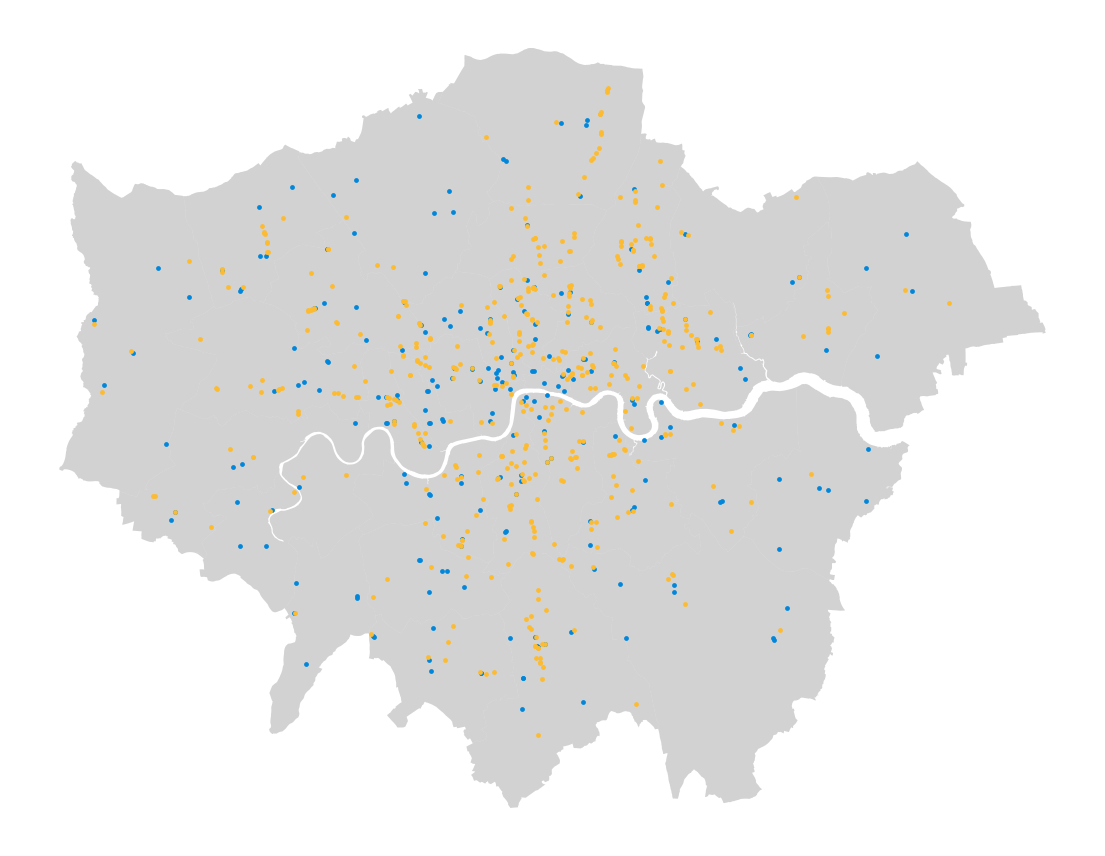

In [221]:
fig, ax = plt.subplots(figsize=(14, 14))
cols = {"International chain": '#0087DC', 'Local/independent': '#FDBB30'}

london.plot(ax=ax, color="grey", alpha=0.35, zorder=1)

for ctype, data in gdf.groupby('chain_binary'):
    color = cols[ctype]
    label = ctype
    data.plot(color=color, ax=ax, label=label, edgecolor="#333333", linewidth=0, markersize=12,alpha=1)

#gdf.plot(ax=ax, color="black", markersize=5, alpha=0.35, zorder=2)
#cx.add_basemap(ax=ax, crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLabels, attribution="", zoom=10)
ax.axis("off")

### Choropleth independent vs chain

In [200]:
london

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,Independent,International chain,Local chain,Total,Chain_ratio
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"MULTIPOLYGON (((-36811.020 6679699.611, -36801...",NaN,5.0,1.0,6.0,0.833333
1,Croydon,E09000008,8649.441,0.000,F,None,None,"MULTIPOLYGON (((-7126.807 6677851.759, -7132.8...",12.0,10.0,14.0,36.0,0.277778
2,Bromley,E09000006,15013.487,0.000,F,None,None,"MULTIPOLYGON (((1350.414 6674461.413, 1331.568...",5.0,8.0,2.0,15.0,0.533333
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"MULTIPOLYGON (((-27224.557 6708199.030, -27237...",5.0,5.0,2.0,12.0,0.416667
4,Ealing,E09000009,5554.428,0.000,F,None,None,"MULTIPOLYGON (((-45845.001 6716316.317, -45850...",10.0,7.0,7.0,24.0,0.291667
5,Havering,E09000016,11445.735,210.763,F,None,None,"MULTIPOLYGON (((17665.610 6712398.496, 17667.0...",1.0,4.0,1.0,6.0,0.666667
6,Hillingdon,E09000017,11570.063,0.000,F,None,None,"MULTIPOLYGON (((-44981.082 6730483.450, -44959...",3.0,6.0,1.0,10.0,0.600000
7,Harrow,E09000015,5046.330,0.000,F,None,None,"MULTIPOLYGON (((-44981.082 6730483.450, -44884...",6.0,7.0,7.0,20.0,0.350000
8,Brent,E09000005,4323.270,0.000,F,None,None,"MULTIPOLYGON (((-21881.928 6715165.737, -21912...",18.0,8.0,10.0,36.0,0.222222
9,Barnet,E09000003,8674.837,0.000,F,None,None,"MULTIPOLYGON (((-22252.361 6740705.704, -22230...",2.0,9.0,2.0,13.0,0.692308


In [271]:
from palettable.cartocolors.diverging import Earth_7, TealRose_7, Temps_7, Temps_7_r
from palettable.colorbrewer.diverging import RdBu_10, PuOr_11, RdGy_8_r,  RdGy_8
from palettable.scientific.diverging import Broc_9, Cork_9, Vik_9
from palettable.cmocean.diverging import Balance_9, Balance_18

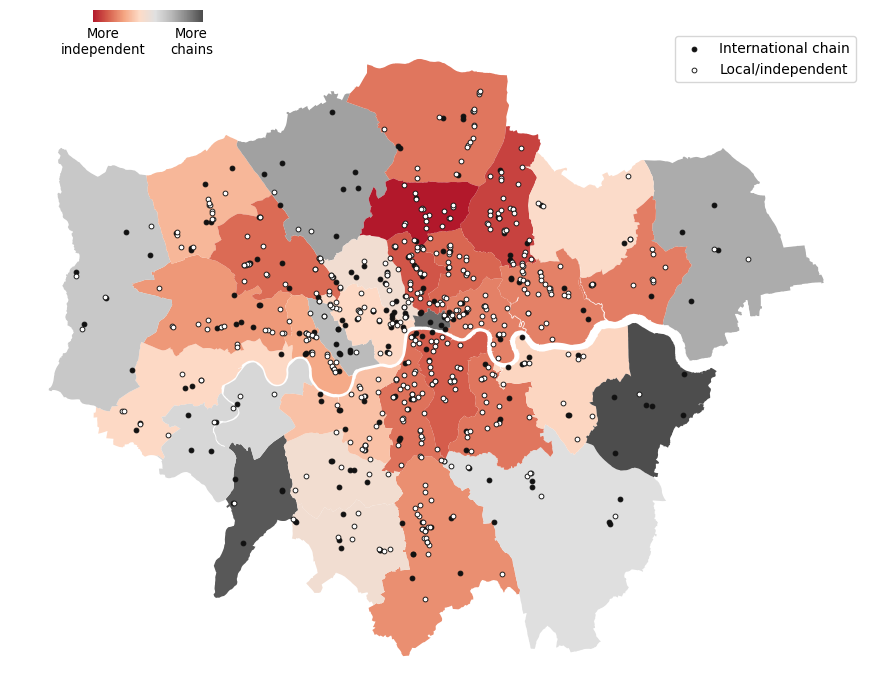

In [278]:
#configuration, colors and fonts
fig, ax = plt.subplots(figsize=(11, 11))
fill = {"International chain": '#111111', 'Local/independent': '#FFFFFF'}
color = RdGy_8

# ======
#plot london boroughs and chicken shopt
london.plot(ax=ax, column="Chain_ratio", alpha=1, zorder=1, cmap=color.mpl_colormap)
for ctype, data in gdf.groupby('chain_binary'):
    data.plot(color=fill[ctype], ax=ax, label=ctype, edgecolor="#111111", linewidth=0.65, markersize=12,alpha=1,
              vmin=0, vmax=1)

#======
#legend    
plt.legend()
    
#======
#colorbar
cbaxes = fig.add_axes([0.20, 0.8, 0.10, 0.011]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=color.mpl_colormap)                      
cb = plt.colorbar(cmappable, cax=cbaxes, anchor=(1,1.2), orientation='horizontal', drawedges=False,ticks=[0.1,0.9])
cb.set_ticklabels(["More\nindependent","More\nchains" ], size=9.5, va='top')
cbaxes.tick_params(size=0)
cb.outline.set_visible(False)
#cb.outline.set_linewidth(0.5)
    
ax.axis("off")

plt.show()

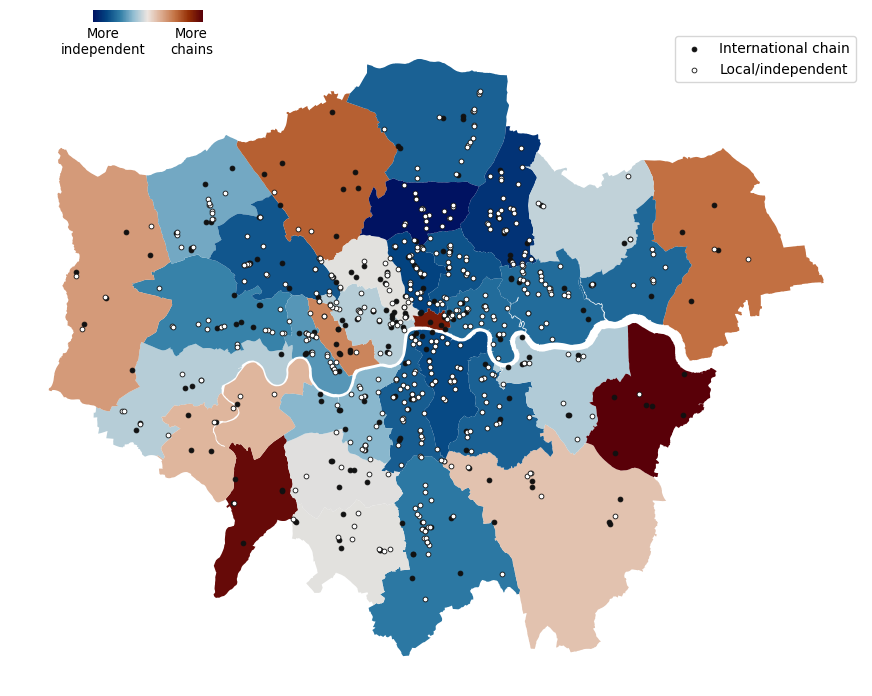

In [261]:
#configuration, colors and fonts
fig, ax = plt.subplots(figsize=(11, 11))
fill = {"International chain": '#111111', 'Local/independent': '#FFFFFF'}
color = Vik_9

# ======
#plot london boroughs and chicken shopt
london.plot(ax=ax, column="Chain_ratio", alpha=1, zorder=1, cmap=color.mpl_colormap)
for ctype, data in gdf.groupby('chain_binary'):
    data.plot(color=fill[ctype], ax=ax, label=ctype, edgecolor="#111111", linewidth=0.6, markersize=12,alpha=1,
              vmin=0, vmax=1)

#======
#legend    
plt.legend()
    
#======
#colorbar
cbaxes = fig.add_axes([0.20, 0.8, 0.10, 0.011]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=color.mpl_colormap)                      
cb = plt.colorbar(cmappable, cax=cbaxes, anchor=(1,1.2), orientation='horizontal', drawedges=False,ticks=[0.1,0.9])
cb.set_ticklabels(["More\nindependent","More\nchains" ], size=9.5, va='top')
cbaxes.tick_params(size=0)
cb.outline.set_visible(False)
#cb.outline.set_linewidth(0.5)
    
ax.axis("off")

plt.show()

In [234]:
color.mpl_colormap

AttributeError: 'str' object has no attribute 'mpl_colormap'

In [49]:
df["name"].value_counts()

KFC                      121
Nando's                  113
Morley's                  37
Chicken Cottage           23
Perfect Fried Chicken     15
                        ... 
Dixie Grill                1
Bite House                 1
Chicken n Grill            1
Chicken Hut                1
Chesters                   1
Name: name, Length: 300, dtype: int64

In [77]:
london

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"MULTIPOLYGON (((-36811.020 6679699.611, -36801..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"MULTIPOLYGON (((-7126.807 6677851.759, -7132.8..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"MULTIPOLYGON (((1350.414 6674461.413, 1331.568..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"MULTIPOLYGON (((-27224.557 6708199.030, -27237..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"MULTIPOLYGON (((-45845.001 6716316.317, -45850..."
5,Havering,E09000016,11445.735,210.763,F,None,None,"MULTIPOLYGON (((17665.610 6712398.496, 17667.0..."
6,Hillingdon,E09000017,11570.063,0.000,F,None,None,"MULTIPOLYGON (((-44981.082 6730483.450, -44959..."
7,Harrow,E09000015,5046.330,0.000,F,None,None,"MULTIPOLYGON (((-44981.082 6730483.450, -44884..."
8,Brent,E09000005,4323.270,0.000,F,None,None,"MULTIPOLYGON (((-21881.928 6715165.737, -21912..."
9,Barnet,E09000003,8674.837,0.000,F,None,None,"MULTIPOLYGON (((-22252.361 6740705.704, -22230..."


## Example

In [10]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="DE"][admin_level=2]->.searchArea;

(node["amenity"="biergarten"](area.searchArea);
 way["amenity"="biergarten"](area.searchArea);
 rel["amenity"="biergarten"](area.searchArea);
);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

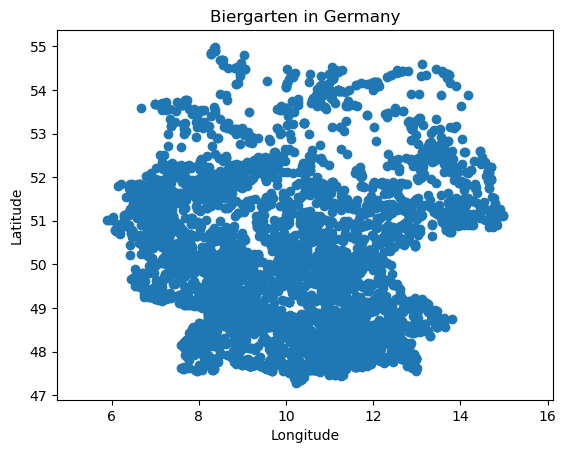

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Collect coords into list
coords = []
for element in data['elements']:
  if element['type'] == 'node':
    lon = element['lon']
    lat = element['lat']
    coords.append((lon, lat))
  if 'center' in element:
    lon = element['center']['lon']
    lat = element['center']['lat']
    coords.append((lon, lat))# Convert coordinates into numpy array
X = np.array(coords)
plt.plot(X[:, 0], X[:, 1], 'o')
plt.title('Biergarten in Germany')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

In [13]:
data

{'version': 0.6,
 'generator': 'Overpass API 0.7.59 e21c39fe',
 'osm3s': {'timestamp_osm_base': '2022-11-05T17:27:24Z',
  'timestamp_areas_base': '2022-11-05T16:48:50Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': [{'type': 'node',
   'id': 23662384,
   'lat': 50.5112014,
   'lon': 6.9939896,
   'tags': {'amenity': 'biergarten'}},
  {'type': 'node',
   'id': 25338407,
   'lat': 49.9534891,
   'lon': 10.8750469,
   'tags': {'amenity': 'biergarten', 'noname': 'yes'}},
  {'type': 'node',
   'id': 26865440,
   'lat': 52.4333644,
   'lon': 13.190734,
   'tags': {'amenity': 'biergarten',
    'name': 'Spinnerbrücke',
    'note': 'Motorradtreff',
    'toilets:wheelchair': 'no',
    'website': 'http://www.spinner-bruecke.de/',
    'wheelchair': 'yes'}},
  {'type': 'node',
   'id': 27159163,
   'lat': 48.9694336,
   'lon': 8.3902958,
   'tags': {'amenity': 'biergarten'}},
  {'type': 'node',
   'id': 2731

In [ ]:
area[name="London"][admin_level=5];
( node["amenity"="pub"](area);
  way["amenity"="pub"](area);
  rel["amenity"="pub"](area);
);
out center;